# GÖREV 1

* Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
df = pd.read_csv("Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [107]:
# Genel Resmi bir görelim.

def check_df(dataframe, head=5):
    print("############## Shape ##############")
    print(dataframe.shape)
    
    print("############## Types ##############")
    print(dataframe.dtypes)
    
    print("############## Head ##############")
    print(dataframe.head(head))
    
    print("############## Tail ##############")
    print(dataframe.tail(head))
    
    print("############## NA ##############")
    print(dataframe.isnull().sum())
    
    print("############## Quantiles ##############")
    print(dataframe.describe([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_df(df)

############## Shape ##############
(322, 20)
############## Types ##############
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
############## Head ##############
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.000       

In [108]:
# Datamızda 3 tane kategorik değişken olduğunu biliyorum.
# "Salary" değişkeni ise hem nümerik hem de bağımlı değişkenimiz.

# Tüm nümerik kolonlarımızı tutuyorum
num_cols = [col for col in df.columns if col !="Salary" and df[col].dtype in ["int64", "float64"]]

# Tüm kategorik değişkenleri tutuyorum.
cat_cols = [col for col in df.columns if col !="Salary" and col not in num_cols] # if df[col].dtype in ["object", "bool", "category"]

print("Nümerik kolonlar (Bağımlı değişken hariç): ", num_cols)
print("#"*11)
print("Kategorik kolonlar: ", cat_cols)

Nümerik kolonlar (Bağımlı değişken hariç):  ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
###########
Kategorik kolonlar:  ['League', 'Division', 'NewLeague']


## Outliers

In [109]:
# Sınırları bulalım

# 0.05-0.95 belirleyerek çok az bir kırpma payı bıraktım.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95): # eşik değerlerinie 0.05-0.95 olarak güncelledik.
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [110]:
# Aykırı değer var mı yok mu?

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    filter1 = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    return dataframe[filter1].any(axis=None) # True/False --> Outlier Var mı? Yok mu?

In [112]:
# Aykırı değerlere bakalım

for col in num_cols:
    print(col, check_outlier(df, col)) # 0.05-0.95 threshold'lara göre kontrol ediyor fonksiyonumuz.
    
# 0.05-0.95 değerlerine göre değişkenlerimizde herhangi bir outlier görünmüyor.
# Bu yüzden herhangi bir işlem yapmayacağım.

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False


## Missing Values

In [113]:
# Sadece salary değişkeninde 59 eksik değer var.
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [114]:
# Kategorik değişkenlere göre "Salary" bağımlı değişkenimizin ortalaması

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)
    print("#"*20)

        TARGET_MEAN
League             
A           542.000
N           529.118
####################
          TARGET_MEAN
Division             
E             624.271
W             450.877
####################
           TARGET_MEAN
NewLeague             
A              537.113
N              534.554
####################


> * Sonuçları incelediğimde "League" ve "NewLeague" değişkenlerine göre "Salary" bağımlı değişkenimiz arasında keskin bir fark söz konusu değil.
> * "Division" değişkeni ile "Salary" arasında keskin bir fark söz konusu. Bu durum "Division" yani oyuncunun oynadığı pozisyona göre etkili olduğunu gösteriyor. Bu yüzden eksik olan "Salary" değişkenlerini "Division" kırılımında doldurmak mantıklı olabilir.

In [115]:
df["Division"].value_counts()

W    165
E    157
Name: Division, dtype: int64

In [116]:
# "Division" kırılımında "Salary" değişkenlerine atama yapacağız.
# "Division = E" için 624.271
# "Division = W için 450.877"

df["Salary"] = df["Salary"].fillna(df.groupby("Division")["Salary"].transform("mean"))

In [117]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,624.271,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [118]:
df.isnull().sum().sum() # Hiç eksik değer kaldı mı?

0

---  

* Outliersları hallettik. 
* Missing Valueları hallettik. 
* Herhangi bir feature engineering yapmadan "base" bir model kuracağım. 

---

## Encoding & Scaling

In [119]:
df.head()
# Elimizdeki kategorik değişkenler nominal ve 2 sınıflı olduğu için OneHotEncoding yapabilirim.

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,624.271,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [120]:
num_cols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

In [121]:
cat_cols

['League', 'Division', 'NewLeague']

In [122]:
# OHE fonksiyonumuz

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,624.271,0,0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500,1,0,1


In [123]:
# Nümerik değişkenler için Encoding yapıyoruz.

def Robust_Scaler(dataframe, num_cols):
    rbScaler = RobustScaler()
    dataframe[num_cols] = rbScaler.fit_transform(dataframe[num_cols])
    return dataframe

df = Robust_Scaler(df, num_cols)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,-0.337,-0.411,-0.583,-0.465,-0.408,-0.677,-0.714,-0.526,-0.520,-0.480,-0.509,-0.567,-0.575,1.085,-0.041,1.750,624.271,0,0,0
1,-0.251,-0.205,-0.083,-0.619,-0.163,0.129,1.143,0.489,0.385,0.414,0.174,0.573,0.752,1.947,0.022,0.500,475.000,1,1,1
2,0.388,0.466,0.833,0.465,0.762,1.323,-0.429,-0.098,-0.060,0.336,-0.054,0.135,0.340,3.096,0.267,1.000,480.000,0,1,0
3,0.454,0.616,1.000,0.439,0.925,0.065,0.714,1.191,1.255,2.467,1.364,1.830,0.675,-0.056,-0.179,-0.375,500.000,1,0,1
4,-0.228,-0.123,0.167,-0.232,-0.054,-0.161,-0.571,-0.493,-0.479,-0.336,-0.467,-0.517,-0.506,2.749,0.003,-0.250,91.500,1,0,1


## Base Model

In [124]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

# Holdout yöntemi

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


# MSE skorumuz
print("MSE:", mean_squared_error(y_test, y_pred))

# RMSE skorumuz
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# MAE
print("MAE:", mean_absolute_error(y_test, y_pred))



MSE: 117457.81252638833
RMSE: 342.7211877406886
MAE: 233.88558787326338


In [125]:
# 10 katlı CV RMSE

np.mean(np.sqrt(-cross_val_score(rf_model, X, y, cv=10, scoring="neg_mean_squared_error")))

287.65210529454276

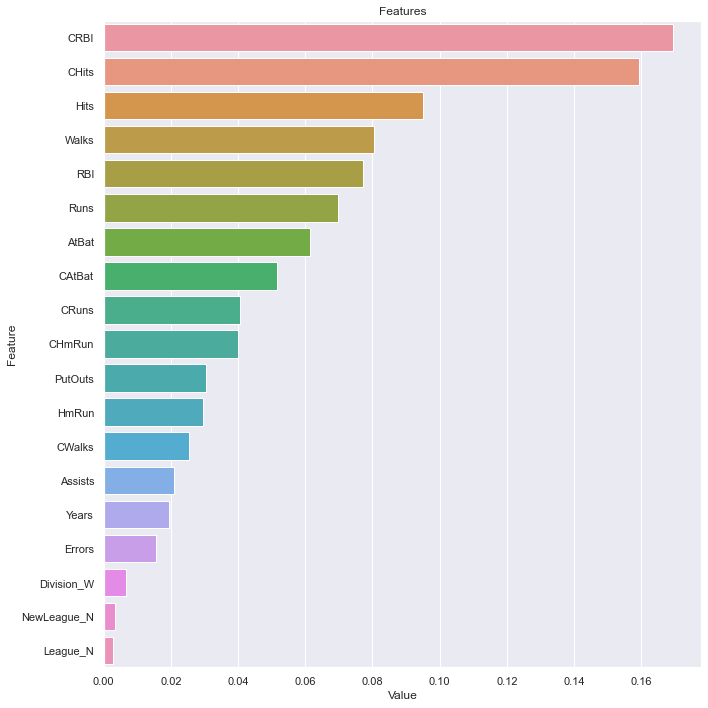

In [126]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

# Feature Engineering + Main Model

* GÖREV 1 kısmında oluşturduğum base model ile şimdi oluşturacağım ana modeli karşılaştıracağım. 
* Bu bölümde feature engineering üzerine yoğunlaşarak yeni bir model oluşturacağım. 
* Daha sonra elde ettiğim skorları "base model" kapsamında elde ettiğim skorlar ile karşılaştıracağım.

In [51]:
dff = pd.read_csv("Hitters.csv")
dff.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [52]:
# Genel Resmi bir görelim.

def check_df(dataframe, head=5):
    print("############## Shape ##############")
    print(dataframe.shape)
    
    print("############## Types ##############")
    print(dataframe.dtypes)
    
    print("############## Head ##############")
    print(dataframe.head(head))
    
    print("############## Tail ##############")
    print(dataframe.tail(head))
    
    print("############## NA ##############")
    print(dataframe.isnull().sum())
    
    print("############## Quantiles ##############")
    print(dataframe.describe([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_df(dff)

############## Shape ##############
(322, 20)
############## Types ##############
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
############## Head ##############
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.000       

In [53]:
# Değişkenleri ayıklama

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """
    
    #cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    
    # Encoding halde tutulan ve "cat_th" den daha az unique değişkene sahip cat. değişkenler
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype != "O" and dataframe[col].nunique() < cat_th]
    
    # "Name" gibi object olmasına rağmen kategorik olmayan yani her değer birbiriyle bağımsız olabilecek kapasitede. Bir anlam ifade etmeyen
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype == "O" and dataframe[col].nunique() > car_th]
    
    cat_cols = cat_cols + num_but_cat # Kategorik + Encoding Cat.
    cat_cols = [col for col in cat_cols if col not in cat_but_car] # Cardinal olanları ayıkla
    
    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 
    num_cols = [col for col in num_cols if col not in num_but_cat] # Encoding cat. değişkenleri ayıkla
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
    
cat_cols, num_cols, cat_but_car = grab_col_names(dff)
print("\n")
print("#"*5)
print(cat_cols)
print("#"*5)
print(num_cols)
print("#"*5)
print(cat_but_car)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


#####
['League', 'Division', 'NewLeague']
#####
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'Salary']
#####
[]


In [54]:
# Sayısal değişken analizi

def num_summary(dataframe, numerical_col):
    quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

for col in num_cols:
    num_summary(dff, col)
    print("#################")

# CAtBat, Chits gibi değişkenlerde 99%'dan max değere keskin bir artış var. Outlier olmalı ihtimali yüksek.

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64
#################
count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64
#################
count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64
#################
count   322.000
mean     50.910
std      26.024

## Outliers

In [55]:
# Sınırları bulalım

# 0.05-0.95 belirleyerek çok az bir kırpma payı bıraktım.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95): # eşik değerlerinie 0.05-0.95 olarak güncelledik.
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [56]:
# Aykırı değer var mı yok mu?

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    filter1 = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    return dataframe[filter1].any(axis=None) # True/False --> Outlier Var mı? Yok mu?

In [57]:
# Aykırı değerlere bakalım

for col in num_cols:
    print(col, check_outlier(dff, col)) # 0.05-0.95 threshold'lara göre kontrol ediyor fonksiyonumuz.
    
# 0.05-0.95 değerlerine göre değişkenlerimizde herhangi bir outlier görünmüyor.
# Bu yüzden herhangi bir işlem yapmayacağım.

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


## Missing Values

In [61]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0] # NaN değere sahip değişken isimleri
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) # NaN değişken sayıları azalan
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100).sort_values(ascending=False) # NaN değerlerin oranı
    missing_df = pd.concat([n_miss,  np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    
    if na_name: # Eksik değerlerin isimleri gelsin mi?
        return na_columns

missing_values_table(dff)

# Sadece Salary değişkeninde missing value mevcut.

        n_miss  ratio
Salary      59 18.320


* Bu değerler direkt drop edilebilir. Veya "median" - "mean" gibi değerler ile doldurulabilir. 
* Ben "Division" yani oynadığı pozisyon kırılımına göre dolduracağım.

In [62]:
# Kategorik değişkenlere göre "Salary" bağımlı değişkenimizin ortalaması

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))

for col in cat_cols:
    target_summary_with_cat(dff, "Salary", col)
    print("#"*20)

        TARGET_MEAN
League             
A           542.000
N           529.118
####################
          TARGET_MEAN
Division             
E             624.271
W             450.877
####################
           TARGET_MEAN
NewLeague             
A              537.113
N              534.554
####################


In [63]:
# "Division" kırılımında "Salary" değişkenlerine atama yapacağız.
# "Division = E" için 624.271
# "Division = W için 450.877"

dff["Salary"] = dff["Salary"].fillna(dff.groupby("Division")["Salary"].transform("mean"))

In [64]:
dff.isnull().sum().sum()

0

In [65]:
dff.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,624.271,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


## Korelasyon Analizi

In [66]:
dff.corr()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.000,0.968,0.592,0.913,0.821,0.670,0.047,0.236,0.253,0.237,0.267,0.244,0.166,0.318,0.354,0.352,0.341
Hits,0.968,1.000,0.562,0.922,0.811,0.641,0.045,0.228,0.256,0.203,0.262,0.232,0.152,0.311,0.320,0.310,0.384
HmRun,0.592,0.562,1.000,0.651,0.855,0.481,0.116,0.222,0.221,0.493,0.262,0.352,0.233,0.283,-0.106,0.039,0.308
Runs,0.913,0.922,0.651,1.000,0.798,0.732,0.005,0.186,0.205,0.228,0.251,0.206,0.182,0.279,0.221,0.240,0.369
RBI,0.821,0.811,0.855,0.798,1.000,0.616,0.146,0.295,0.308,0.442,0.323,0.393,0.251,0.343,0.107,0.193,0.401
Walks,0.670,0.641,0.481,0.732,0.616,1.000,0.136,0.277,0.281,0.332,0.338,0.309,0.425,0.300,0.150,0.129,0.401
Years,0.047,0.045,0.116,0.005,0.146,0.136,1.000,0.920,0.904,0.727,0.883,0.869,0.839,-0.005,-0.081,-0.162,0.343
CAtBat,0.236,0.228,0.222,0.186,0.295,0.277,0.920,1.000,0.995,0.799,0.983,0.949,0.907,0.062,0.002,-0.067,0.458
CHits,0.253,0.256,0.221,0.205,0.308,0.281,0.904,0.995,1.000,0.783,0.985,0.945,0.891,0.077,-0.003,-0.063,0.482
CHmRun,0.237,0.203,0.493,0.228,0.442,0.332,0.727,0.799,0.783,1.000,0.820,0.929,0.800,0.113,-0.159,-0.138,0.444


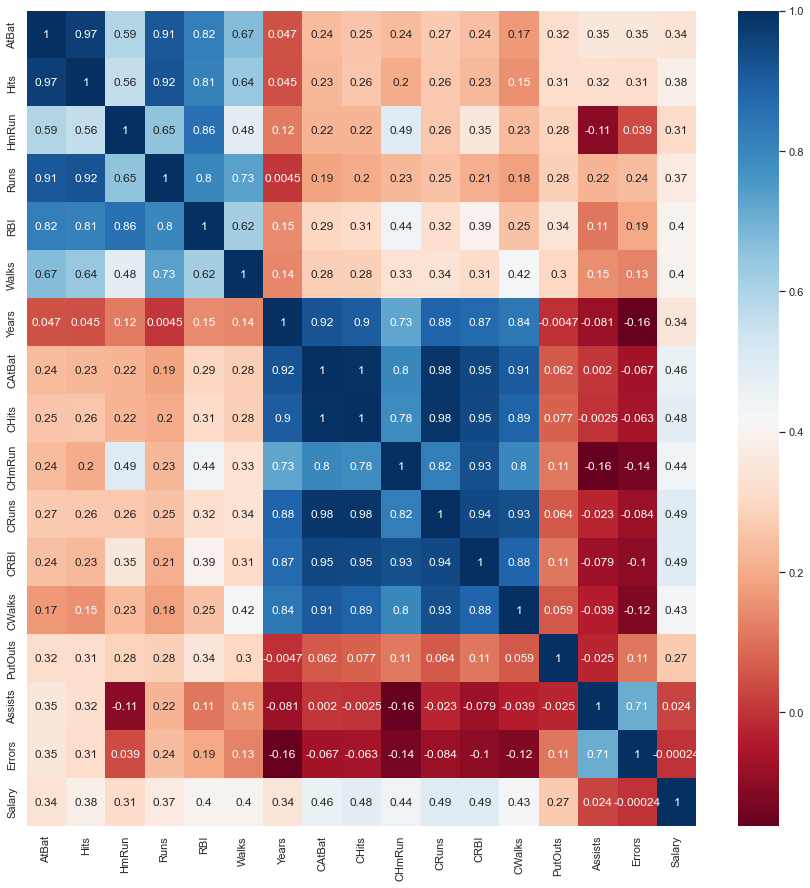

In [67]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.97):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, annot=True, cmap="RdBu")
        plt.show()
    return drop_list

drop_list = high_correlated_cols(dff, plot=True)
dff = dff.drop(drop_list, axis=1)

In [68]:
# Yüksek korelasyonlu değişkenleri attık. Tekrar datamız içerisinden aynı tür değişkenleri yakalayamalıyım.
cat_cols, num_cols, cat_but_car = grab_col_names(dff)
print("\n")
print("#"*5)
print(cat_cols)
print("#"*5)
print(num_cols)
print("#"*5)
print(cat_but_car)

Observations: 322
Variables: 18
cat_cols: 3
num_cols: 15
cat_but_car: 0
num_but_cat: 0


#####
['League', 'Division', 'NewLeague']
#####
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'Salary']
#####
[]


## Feature Engineering

In [71]:
dff['NEW_HitRatio'] = dff['Hits'] / df['AtBat']+1
dff['NEW_RunRatio'] = dff['HmRun'] / df['Runs']+1
dff['NEW_CRunRatio'] = dff['CHmRun'] / df['CRuns']+1

dff['NEW_Avg_AtBat'] = dff['CAtBat'] / df['Years']+1
dff['NEW_Avg_HmRun'] = dff['CHmRun'] / df['Years']+1
dff['NEW_Avg_RBI'] = dff['CRBI'] / df['Years']+1
dff['NEW_Avg_Walks'] = dff['CWalks'] / df['Years']+1

## Encoding & Scaling

In [72]:
cat_cols

['League', 'Division', 'NewLeague']

In [75]:
df.League.unique()

array(['A', 'N'], dtype=object)

In [76]:
df.Division.unique()

array(['E', 'W'], dtype=object)

In [77]:
df.NewLeague.unique()

array(['A', 'N'], dtype=object)

* Kategorik değişkenler 2 sınıfa sahip LabelEncoding veya drop_first ile OneHotEncoding yapılabilir.

In [82]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in dff.columns if 10>=dff[col].nunique() >=2] # OHE yapılacak değişkenleri tuttuk.

dff = one_hot_encoder(dff, ohe_cols).head()

In [83]:
# Nümerik değişkenler için Encoding yapıyoruz.

def Robust_Scaler(dataframe, num_cols):
    rbScaler = RobustScaler()
    dataframe[num_cols] = rbScaler.fit_transform(dataframe[num_cols])
    return dataframe

dff = Robust_Scaler(dff, num_cols)
dff.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHmRun,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_HitRatio,NEW_RunRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_HmRun,NEW_Avg_RBI,NEW_Avg_Walks,League_N,Division_W,NewLeague_N
0,-0.171,-0.429,-0.818,-0.257,-0.382,-2.556,-0.222,-0.436,-1.088,-0.644,-0.776,-0.518,-0.700,1.000,5.771,1.225,1.033,1.033,294.000,2.000,30.000,15.000,0,0,0
1,-0.037,-0.122,-0.273,-0.429,-0.118,0.222,1.222,0.598,0.105,0.402,0.349,0.000,0.300,0.000,-0.200,1.257,1.292,1.215,247.357,5.929,30.571,27.786,1,1,1
2,0.963,0.878,0.727,0.771,0.882,4.333,0.000,0.000,0.000,0.000,0.000,0.691,4.200,0.400,0.000,1.271,1.273,1.281,542.333,22.000,89.667,88.667,0,1,0
3,1.067,1.102,0.909,0.743,1.059,0.000,0.889,1.311,2.842,1.554,0.283,-1.203,-2.900,-0.700,0.800,1.284,1.308,1.272,512.636,21.455,77.182,33.182,1,0,1
4,0.000,0.000,0.000,0.000,0.000,-0.778,-0.111,-0.402,-0.895,-0.598,-0.717,0.482,0.000,-0.600,-15.540,1.271,1.256,1.250,199.000,7.000,24.000,17.500,1,0,1


## Modelleme

In [84]:
y = dff["Salary"]
X = dff.drop(["Salary"], axis=1)

# Holdout yöntemi

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


# MSE skorumuz
print("MSE:", mean_squared_error(y_test, y_pred))

# RMSE skorumuz
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# MAE
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 311.5860114941282
RMSE: 17.6517991007752
MAE: 17.6517991007752


---  

Base Model sonuçları;

* MSE: 117457.81252638833
* RMSE: 342.7211877406886
* MAE: 233.88558787326338 


Görüldüğü gibi devasa bir fark var.

---

In [86]:
# 10 katlı CV RMSE

np.mean(np.sqrt(-cross_val_score(rf_model, X, y, cv=5, scoring="neg_mean_squared_error")))

9.087572114108529

## Feature Importance

In [89]:
X_train.shape

(4, 24)

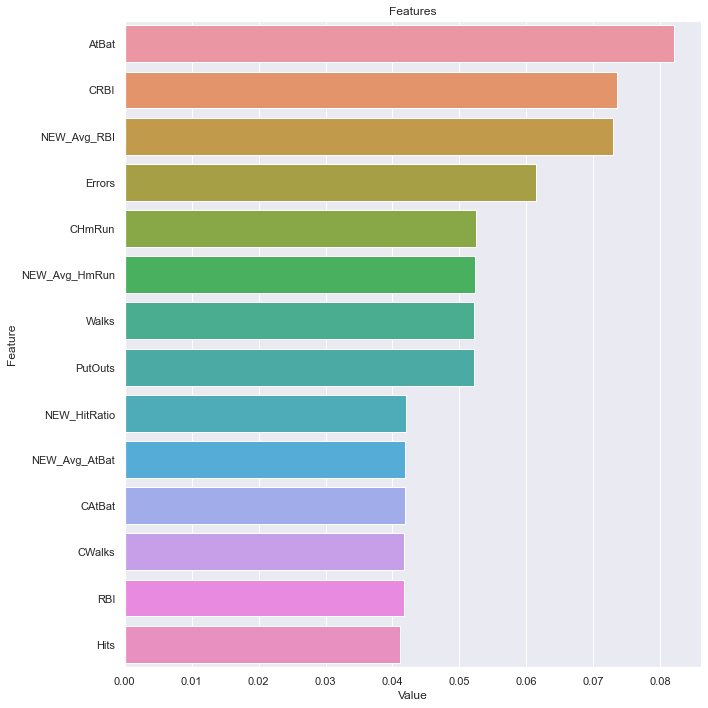

In [90]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train, num=14)

* Hyperparameter Optimizasyounu yapılmadı fakat Base Model ile Feature Engineering yapıldıktan sonraki model arasındaki fark oldukça tatmin edici.